<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: Cancer Detection

## Objective
* To build a dense prediction model
* To begin reading current papers in DNN research

## Deliverable
For this lab, you will turn in a notebook that describes your efforts at creating
a pytorch radiologist. Your final deliverable is a notebook that has (1) a deep network,
(2) method of calculating accuracy,
(3) images that show the dense prediction produced by your network on the pos_test_000072.png image (index 172 in the validation dataset).
This is an image in the test set that your network will not have seen before.
This image, and the ground truth labeling, is shown below.
(And is contained in the downloadable dataset below).

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=200&tok=a8ac31&media=cs501r_f2016:pos_test_000072_output.png)
<img src="http://liftothers.org/dokuwiki/lib/exe/fetch.php?media=cs501r_f2016:pos_test_000072.png" width="200">


## Grading standards
Your notebook will be graded on the following:
* 40% Proper design, creation and debugging of a dense prediction network
* 20% Proper implementation of train/test set accuracy measure
* 20% Tidy visualizations of loss of your dense predictor during training
* 20% Test image output


## Data set
The data is given as a set of 1024×1024 PNG images. Each input image (in
the ```inputs``` directory) is an RGB image of a section of tissue,
and there a file with the same name (in the ```outputs``` directory)
that has a dense labeling of whether or not a section of tissue is cancerous
(white pixels mean “cancerous”, while black pixels mean “not cancerous”).

The data has been pre-split for you into test and training splits.
Filenames also reflect whether or not the image has any cancer at all
(files starting with ```pos_``` have some cancerous pixels, while files
starting with ```neg_``` have no cancer anywhere).
All of the data is hand-labeled, so the dataset is not very large.
That means that overfitting is a real possibility.

## Description
For a video including some tips and tricks that can help with this lab: [https://youtu.be/Ms19kgK_D8w](https://youtu.be/Ms19kgK_D8w)
For this lab, you will implement a virtual radiologist.
You are given images of possibly cancerous tissue samples,
and you must build a detector that identifies where in the tissue cancer may reside.

---

### Part 0
Watch and follow video tutorial:

https://youtu.be/Ms19kgK_D8w

### Part 1
Implement a dense predictor

In previous labs and lectures, we have talked about DNNs that classify an
entire image as a single class. Here, however, we are interested in a more nuanced classification:
given an input image, we would like to identify each pixel that is possibly cancerous.
That means that instead of a single output, our network will output an “image”,
where each output pixel of our network represents the probability that a pixel is cancerous.

___

We will implement our network topology using the “Deep Convolution U-Net” from this paper: [(U-Net: Convolutional Networks for Biomedical Image Segmentation)](https://arxiv.org/pdf/1505.04597.pdf)

![(Figure 1)](https://lh3.googleusercontent.com/qnHiB3B2KRxC3NjiSDtY08_DgDGTDsHcO6PP53oNRuct-p2QXCR-gyLkDveO850F2tTAhIOPC5Ha06NP9xq1JPsVAHlQ5UXA5V-9zkUrJHGhP_MNHFoRGnjBz1vn1p8P2rMWhlAb6HQ=w2400)

```torch.cat``` allows you to concatenate tensors.
```nn.ConvTranspose2d``` is the opposite of ```nn.Conv2d```.
It is used to bring an image from low res to higher res.
[This blog](https://towardsdatascience.com/up-sampling-with-transposed-convolution-9ae4f2df52d0) provides more information about this function in detail.

We can simplify the implementation of this lab by padding the feature maps as they pass through each convolution. This will make the concatenation process easier, though this is technically a departure from the cropping technique outlined in the orginal U-Net paper.

Note that the simplest network we could implement (with all the desired properties)
is just a single convolution layer with two filters and no relu!

**TODO:**
* Understand the U-Net architecture
* Understand ConvTranspose
* Understand concatenation of inputs from multiple prior layers
* Answer Question / Reflect on simplest network with the desired properties:

A network with a single layer and two filters would be an extremely shallow (trivially shallow) U-Net, but it would still need the two filters in order to predict both the probability that a cell is cancerous and the probability that it isn't cancerous. Without relu, such a network would simply be a linear transformation.

In [ ]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

import torch
import torch.nn as nn
from torch.nn.modules.activation import ReLU
from torch.nn.modules.conv import Conv2d
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

WARNING: You may run into an error that says "RuntimeError: CUDA out of memory."

In this case, the memory required for your batch is larger than what the GPU is capable of. You can solve this problem by adjusting the image size or the batch size and then restarting the runtime.

In [2]:
class CancerDataset(Dataset):
  def __init__(self, root, download=True, size=512, train=True):
    if download and not os.path.exists(os.path.join(root, 'cancer_data')):
      datasets.utils.download_url('http://liftothers.org/cancer_data.tar.gz', root, 'cancer_data.tar.gz', None)
      self.extract_gzip(os.path.join(root, 'cancer_data.tar.gz'))
      self.extract_tar(os.path.join(root, 'cancer_data.tar'))

    postfix = 'train' if train else 'test'
    root = os.path.join(root, 'cancer_data', 'cancer_data')
    self.dataset_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'inputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))
    self.label_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'outputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))

  @staticmethod
  def extract_gzip(gzip_path, remove_finished=False):
    print('Extracting {}'.format(gzip_path))
    with open(gzip_path.replace('.gz', ''), 'wb') as out_f, gzip.GzipFile(gzip_path) as zip_f:
      out_f.write(zip_f.read())
    if remove_finished:
      os.unlink(gzip_path)

  @staticmethod
  def extract_tar(tar_path):
    print('Untarring {}'.format(tar_path))
    z = tarfile.TarFile(tar_path)
    z.extractall(tar_path.replace('.tar', ''))

  def __getitem__(self,index):
    img = self.dataset_folder[index]
    label = self.label_folder[index]
    return img[0],label[0][0]

  def __len__(self):
    return len(self.dataset_folder)

In [3]:
# Since we will be using the output of one network in two places(convolution and maxpooling),
# we can't use nn.Sequential.
# We also add padding to preserve the spatial dimensions in the convolutional layers so that
# each maxpool operation is applied ot a layer having a spatial dimension that is a power of
# two since our images are 512x512
# We use the built-in batch normalization and dropout layer

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation = nn.ReLU, up:bool=False):
        super(ConvBlock, self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, (3, 3), stride=1, padding=1),
            activation(),
            nn.Conv2d(out_channels, out_channels, (3,3), stride=1, padding=1),
            activation(),
        )
        self.up = up
        if self.up:
            self.up_conv = nn.ConvTranspose2d(out_channels, out_channels // 2, kernel_size=2, stride=2)

    def forward(self, x):
        if self.up:
            return self.up_conv(self.net(x))
        return self.net(x)

class CancerDetection(nn.Module):
  def __init__(self):
    super(CancerDetection, self).__init__()

    activation = nn.ReLU
    self.down1 = ConvBlock(3, 64, activation=activation)
    self.down2 = ConvBlock(64, 128, activation=activation)
    self.down3 = ConvBlock(128, 256, activation=activation)
    self.down4 = ConvBlock(256, 512, activation=activation)

    self.up1 = ConvBlock(512, 1024, activation=activation, up=True)

    self.up2 = ConvBlock(1024, 512, activation=activation, up=True)
    self.up3 = ConvBlock(512, 256, activation=activation, up=True)
    self.up4 = ConvBlock(256, 128, activation=activation, up=True)

    self.conv1 = Conv2d(128, 64, kernel_size=3, padding=1)
    self.conv2 = Conv2d(64, 64, kernel_size=3, padding=1)
    self.conv3 = Conv2d(64, 2, kernel_size=1, padding=0)

    self.m = nn.MaxPool2d(2)

  def forward(self, input):
    # Contracting Path
    out1 = self.down1(input)
    out2 = self.down2(self.m(out1))
    out3 = self.down3(self.m(out2))
    out4 = self.down4(self.m(out3))
    out5 = self.up1(self.m(out4))

    # Expanding path
    out6 = self.up2(torch.cat((out4, out5), 1))
    out7 = self.up3(torch.cat((out3, out6), 1))
    out8 = self.up4(torch.cat((out2, out7), 1))
    out9 = self.conv1(torch.cat((out1, out8), 1))
    out10 = self.conv2(out9)
    out11 = self.conv3(out10)
    return out11

In [4]:
# Select an image to use to visualize prediction progress
val_dataset = CancerDataset('/data', train=False, download=True)

test_im, test_gt = val_dataset[172]
test_im = test_im.unsqueeze(0).cuda()
del val_dataset

100%|██████████| 2.75G/2.75G [03:44<00:00, 12.2MB/s]


Extracting /data/cancer_data.tar.gz
Untarring /data/cancer_data.tar


In [5]:
def pixelwise_acc(y, y_truth):
    b = y.size(0)
    return (y.argmax(1).squeeze() == y_truth.squeeze()).float().view(b, -1).mean(1)

In [6]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []
test_preds = []

def train():
    try:
        gc.collect()
        # Initialize Datasets
        train_dataset = CancerDataset('/data', train=True, download=True)
        val_dataset = CancerDataset('/data', train=False, download=True)

        # Initialize DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=6)

        # Initialize Model
        model = CancerDetection()
        model = model.cuda()

        # Initialize Objective and Optimizer and other parameters
        objective = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr = 1e-4)

        epochs = 5

        for epoch in range(epochs):
            loop = tqdm(total=len(train_loader) * epochs, position = 0, leave=False)
            for batch, (x, y_truth) in enumerate(train_loader):
                x, y_truth = x.cuda(), y_truth.cuda()

                optimizer.zero_grad()
                y_hat = model(x)

                loss = objective(y_hat, y_truth.long())
                loss.backward()
                train_losses.append(loss.item())

                accuracy = pixelwise_acc(y_hat, y_truth).mean().item()
                train_accs.append(accuracy)
                mem = torch.cuda.memory_allocated() / 1e9

                loop.set_description('epoch:{}, loss:{:.4f}, accuracy:{:.3f}, mem:{:.2f}'.format(epoch + 1, loss, accuracy, mem))
                loop.update(True)

                optimizer.step()

            test_preds.append(model(test_im).cpu())
            vals = []
            val_mean = 0
            with torch.no_grad():
                for x, y_truth in val_loader:
                    gc.collect()
                    x, y_truth = x.cuda(), y_truth.cuda()
                    y_hat = model(x)

                    vals.append(objective(y_hat, y_truth.long()).item())
                    val_mean += pixelwise_acc(y_hat, y_truth).sum().item()
                val_losses.append((len(train_losses), np.mean(vals)))
                val_accs.append((len(train_accs), val_mean / len(val_dataset)))
        loop.close()

        return model
    except:
        __ITB__()

torch.manual_seed(42)
np.random.seed(42)

model = train()


___

### Part 2

Plot performance over time

Please generate two plots:

 One that shows loss on the training and validation set as a function of training time.

 One that shows accuracy on the training and validation set as a function of training time.

 Make sure your axes are labeled!

**TODO:**
* Plot training/validation loss as function of training time (epochs are fine)
* Plot training/validation accuracy as function of training time (epochs are fine)

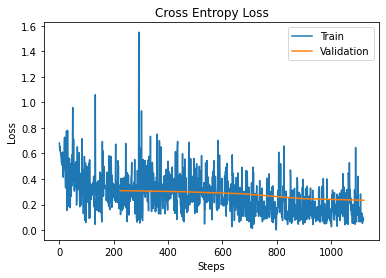

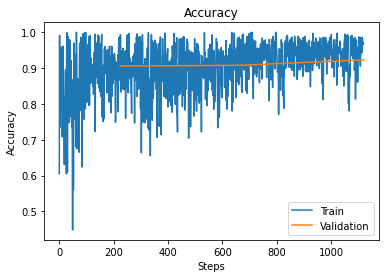

In [ ]:
# Your plotting code here
x, val = zip(*val_losses)
plt.plot(train_losses, label = "Train")
plt.plot(x, val, label = "Validation")
plt.title("Cross Entropy Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

x, val = zip(*val_accs)
plt.plot(train_accs, label = "Train")
plt.plot(x, val, label = "Validation")
plt.title("Accuracy")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**NOTE:**

Guessing that the pixel is not cancerous every single time will give you an accuracy of ~ 85%.
Your trained network should be able to do better than that (but you will not be graded on accuracy).
This is the result I got after 1 hour or training.

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=400&tok=d23e0b&media=cs501r_f2016:training_accuracy.png)
![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=400&tok=bb8e3c&media=cs501r_f2016:training_loss.png)

___

### Part 3

Generate at least 5 predictions on the pos_test_000072.png image and display them as images. These predictions should be made at a reasonable interval (e.g. every epoch).

To do this, calculate the output of your trained network on the pos_test_000072.png image,
then make a hard decision (cancerous/not-cancerous) for each pixel.
The resulting image should be black-and-white, where white pixels represent things
you think are probably cancerous.

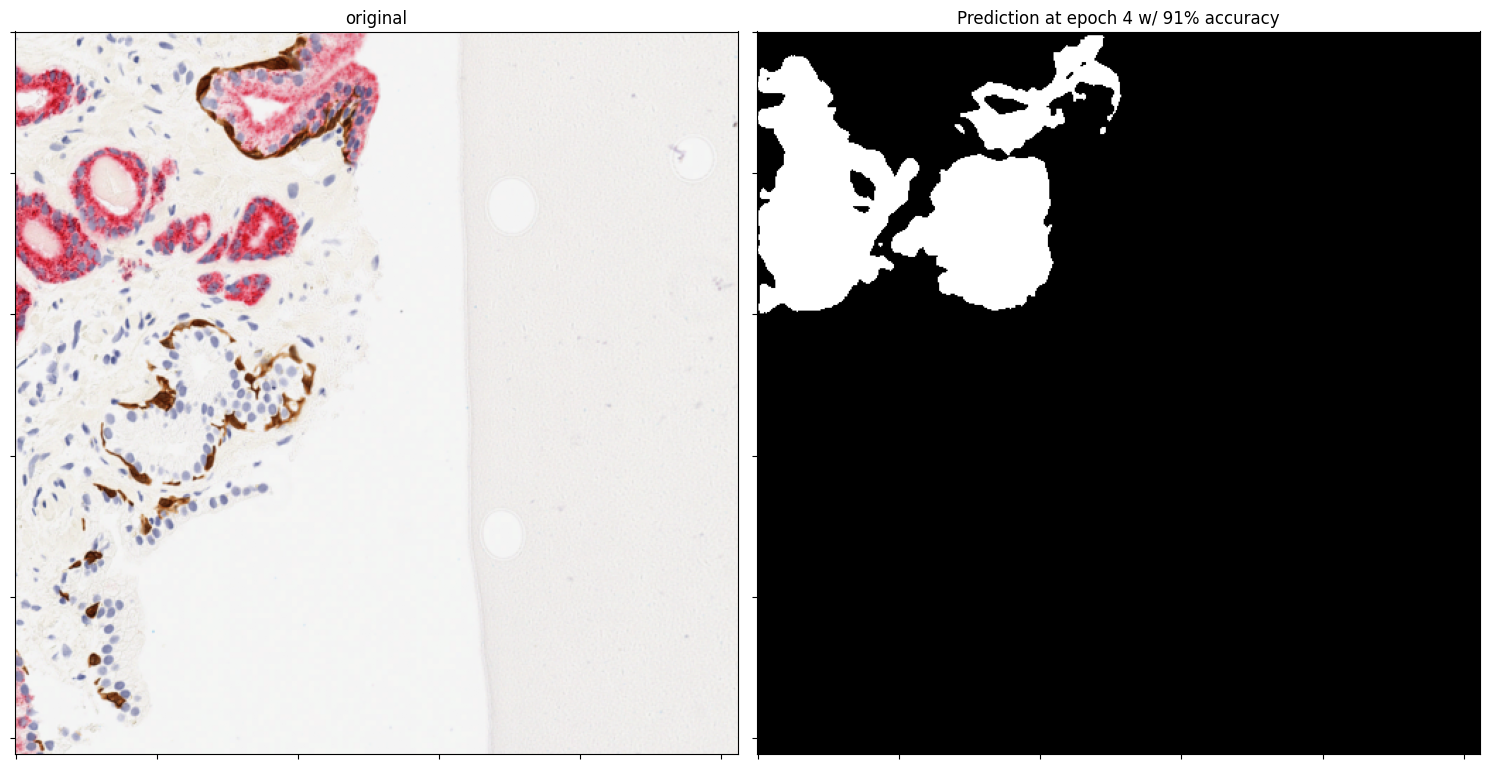

In [17]:
epoch = 4
test_pred = test_preds[epoch - 1]
test_pred_np = np.rollaxis(test_pred.cpu().detach().squeeze(0).numpy(), 0, 3)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 9))
axs[0].imshow(np.rollaxis(test_im.cpu().squeeze(0).numpy(), 0, 3))
axs[0].set_yticklabels([])
axs[0].set_xticklabels([])
axs[0].set_title("original")


axs[1].imshow(test_pred_np.argmax(2), cmap='gray')
axs[1].set_title(f"Prediction at epoch {epoch} w/ {int(100 * val_accs[epoch - 1][1])}% accuracy")
axs[1].set_xticklabels([])
axs[1].set_yticklabels([])
fig.tight_layout()
fig.savefig('cancer_detection.png', dpi=400)
plt.show()

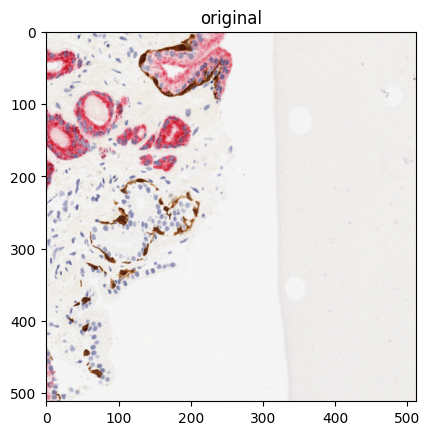

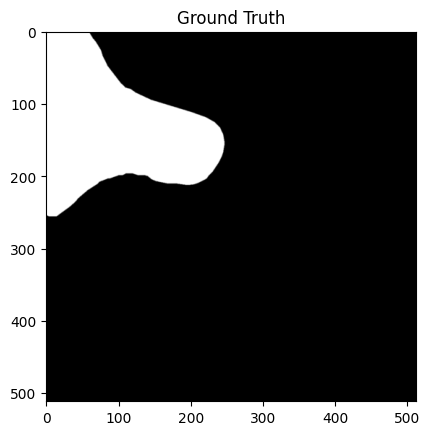

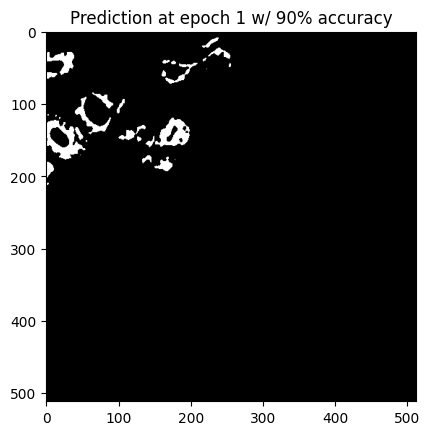

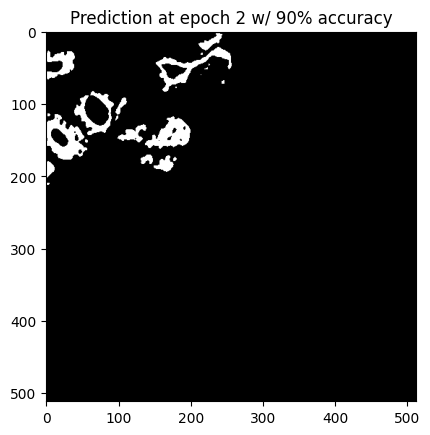

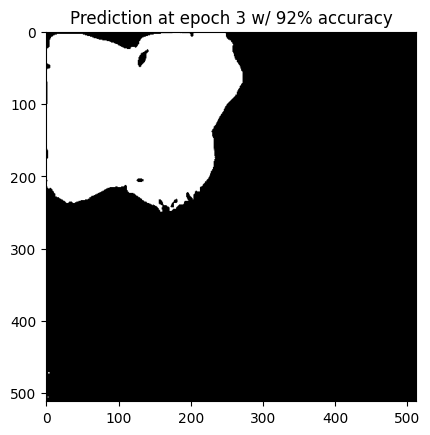

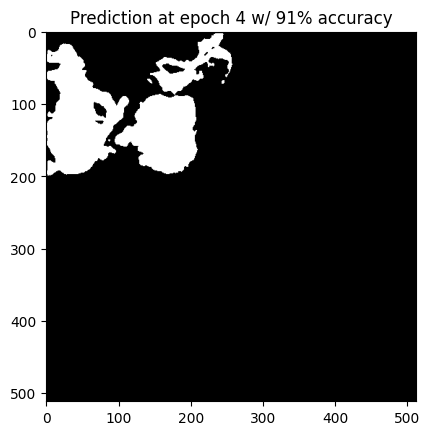

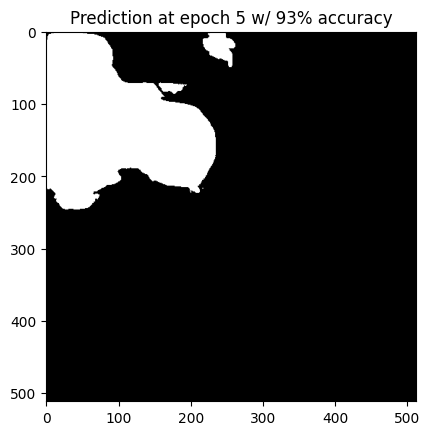

In [10]:
# Code for testing prediction on an image
plt.imshow(np.rollaxis(test_im.cpu().squeeze(0).numpy(), 0, 3))
plt.title("original")
plt.show()
plt.imshow(test_gt.numpy(), cmap='gray')
plt.title("Ground Truth")
plt.show()

for epoch, test_pred in enumerate(test_preds):
    test_pred_np = np.rollaxis(test_pred.cpu().detach().squeeze(0).numpy(), 0, 3)
    plt.imshow(test_pred_np.argmax(2), cmap='gray')
    plt.title(f"Prediction at epoch {epoch + 1} w/ {int(100 * val_accs[epoch][1])}% accuracy")
    plt.show()